In [1]:
import numpy as np
from skimage.transform import downscale_local_mean
import cv2
from scipy.spatial.distance import cdist

%matplotlib inline
from matplotlib import pyplot as plt

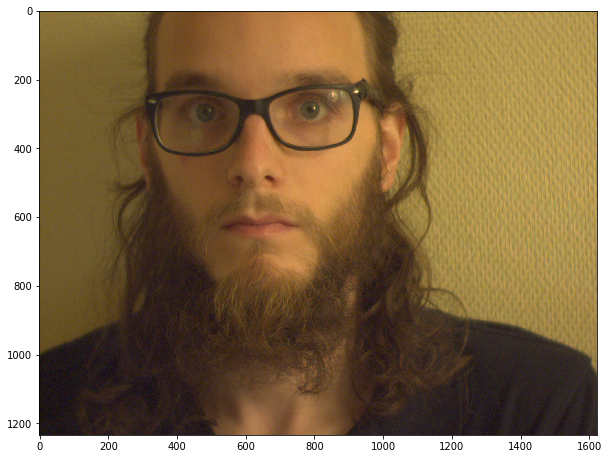

In [4]:
img = cv2.imread("/home/terbe/Basler-records/FVP_proba2.png")
RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(RGB_im)
plt.show()

# 1.) Step - Downsample the image and reshape
Downsample the image to create 50x50 subregions and reshape for further use.

(50, 65, 3)


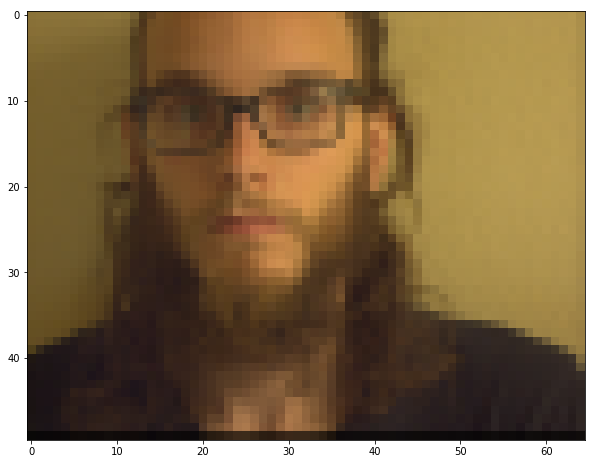

In [14]:
    # Downsample the image
    Id = downscale_local_mean(RGB_im, (25, 25, 1))
    print Id.shape
    
    plt.figure(figsize=(10,8))
    plt.imshow(Id.astype(int))
    plt.show()

In [15]:
# Reshape Id
Id = np.reshape(Id, (Id.shape[0]*Id.shape[1], 3))
print Id.shape

(3250, 3)


# 2.) Step - Initensity normalization

Normalize by color channels in order to eliminate intensity variations, because we want to cluster subregions by only its color feature.

$$ I_n(x, c) = \dfrac{I_d(x, c)}{\sum_{c=1}^3 I_d(x, c)} $$

where x denotes a specific subregion and c the color channel

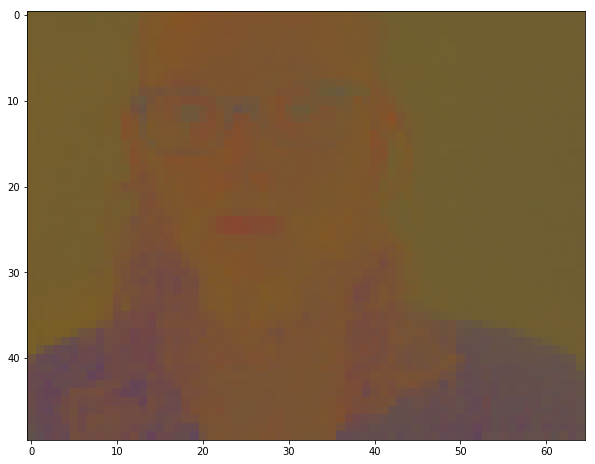

In [17]:
In = np.zeros(Id.shape)
norm_fact = np.sum(Id, axis=1)

for idx, n in enumerate(norm_fact):
    In[idx, :] = Id[idx, :]/norm_fact[idx]   # divide each row by its sum
    
plt.figure(figsize=(10,8))
plt.imshow(np.reshape((In*256).astype(int), (50, 65, 3)))
plt.show()

# 3.) Step - Creating similarity/affinity matrix

This matrix denotes the similarities between subregion colors...

$$ A_{x,y} = || I_n(x) - I_n(y) ||_{L2} $$
where
$$ I_n(x) - I_n(y) = [I_n(x,1)-I_n(y,1);\quad  I_n(x, 2)-I_n(y, 2);\quad  I_n(x, 3)-I_n(y, 3)] $$
and

$$ ||.||_{L2}$$ is the euclidean norm.

In [18]:
# Create Affinity matrix
A = cdist(In, In,  metric='euclidean')
print A.shape

(3250, 3250)


In [20]:
# Check if it is OK
A12 = np.sqrt(np.power(In[0, 0]-In[1, 0],2) + np.power(In[0, 1]-In[1, 1],2) + np.power(In[0, 2]-In[1, 2],2))
print A12
print A[0,1]

0.0013942612558388587
0.0013942612558388587


# 4.) Step - Singular Value Decomposition

$$ A = USU^T $$

Each eigenvector describes a group of patches havng a similar color-feature

In [22]:
# Compute the eigenvectors
u, _, _ = np.linalg.svd(A)

print u.shape

(3250, 3250)


In [23]:
# Create the weights with the top ranked eigen vectors
w = np.zeros((u.shape[0], 4*2))

w[:, 0:4] = u[:, 0:4]
w[:, 4:2*4] = -1*u[:, 0:4]

print w.shape

(3250, 8)


In [24]:
# Weights cannot be negative numbers (shift with the minimum)
w = w-np.min(w[:])

# Normalize
norm_fact = np.sum(w, 0)
norm_fact.shape

for i in range(len(norm_fact)):
    w[:, i] = w[:, i]/norm_fact[i]

## The Top 4 ranked weightening mask:

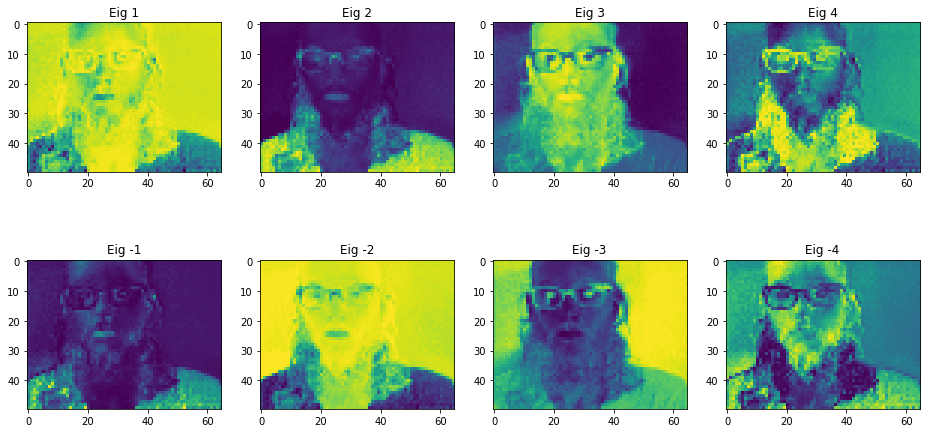

In [46]:
f, ax = plt.subplots(2, 4, figsize=(16, 8))
for idx in range(4):
    ax[0, idx].imshow(np.reshape((w[:, idx]/np.max(w[:, 0])*256).astype(int), (50, 65)) )
    ax[0, idx].set_title("Eig %s" % int(idx+1))
    ax[1, idx].imshow(np.reshape((w[:, idx+4]/np.max(w[:, 0])*256).astype(int), (50, 65)) )
    ax[1, idx].set_title("Eig -%s" % int(idx+1))
